# Import packages

In [1]:
from ast import literal_eval
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons

import itertools
from dijkstar import Graph, find_path

from helper_functions import open_processed_gtfs, open_delays, open_stations

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'
LINKS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_links_corrected.geojson'
STATIONS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_stations_corrected.geojson'
RESULTS_FILEPATH = r'First model results\\D05 to D06.csv'
RESULTS_TOTAL_FILEPATH = r'Second model results\forward_total_exponnorm.csv'
# RESULTS_ABOVE_ZERO_FILEPATH = r'First model results\\D05 to D06 above zero.csv'


distribution = stats.exponnorm
# distribution_above_zero = stats.halflogistic

# Load data

In [3]:
gtfs_stations = open_stations(STATIONS_FILEPATH)
gtfs_stations.head(5)

,stop_id,stop_name,connections,geometry
0,E02,SHAW METRO STATION,"[[E03, E01], [E01, E03]]",POINT (1306094.353 454461.868)
1,D11,CHEVERLY METRO STATION,"[[D10, D12], [D12, D10]]",POINT (1336488.46 455202.936)
2,G02,CAPITOL HEIGHTS METRO STATION,"[[G01, G03], [G03, G01]]",POINT (1337007.377 445376.966)
3,E03,U STREET METRO STATION,"[[E04, E02], [E02, E04]]",POINT (1304034.044 455361.654)
4,D12,LANDOVER METRO STATION,"[[D11, D13], [D13, D11]]",POINT (1343622.123 461562.939)


In [4]:
delays = open_delays(DELAYS_FILEPATH)

# Assign dates to delays
delays['date'] = [date.date() for date in delays['sched_arrival_time']]

delays.head(3)

Amount of delay values: 3_802_649


,line_name,trip_id,shape_id,stop,sched_arrival_time,previous_stop,next_stop,real_arrival_time,delay,timestep,date
0,BLUE,3121350_18154_2019-09-14,46,G05,2019-09-14 06:54:00,NaN,G04,2019-09-14 06:46:04,-476.0,6.0,2019-09-14
1,BLUE,3121350_18154_2019-09-14,46,G04,2019-09-14 06:57:00,G05,G03,2019-09-14 06:56:12,-48.0,6.0,2019-09-14
2,GREEN,3120258_18154_2019-09-14,117,F11,2019-09-14 07:00:00,NaN,F10,2019-09-14 06:45:42,-858.0,7.0,2019-09-14


In [5]:
results_second_model = pd.read_csv(RESULTS_TOTAL_FILEPATH)
results_second_model['dist_params'] = [literal_eval(dist_params) for dist_params in results_second_model['dist_params'].values]
if 'Unnamed: 0' in results_second_model.columns:
    results_second_model = results_second_model.drop(columns=['Unnamed: 0'])
results_second_model.head(5)

,timestep,from_stop,to_stop,dist_params
0,5.0,A01/C01,A02,"[1.6932084843842516, -46.61632500463405, 10.47..."
1,6.0,A01/C01,A02,"[1.4724190201183482, -43.87800761255711, 11.90..."
2,7.0,A01/C01,A02,"[1.4121326845647255, -38.864132458264876, 12.0..."
3,8.0,A01/C01,A02,"[1.2850950019381768, -33.17069368712228, 13.88..."
4,9.0,A01/C01,A02,"[1.9929803709128393, -38.393698881037736, 10.6..."


In [6]:
results_first_model = pd.read_csv(RESULTS_FILEPATH, converters={"connection": eval, "other_connection": eval, 'dist_params': eval})
results_first_model.head(5)

,connection,delay_range,timestep,other_connection,future_timestep,dist_params
0,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",5.0,"[1.9363084332005704, -44.1373622808718, 35.677..."
1,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",6.0,"[0.8006572486325675, -32.32943211393756, 53.75..."
2,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",7.0,"[0.6121180864618025, -33.56552270335543, 53.07..."
3,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",8.0,"[1.6210548244218175, -62.26000703681639, 45.26..."
4,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",9.0,"[1.0275163967240994, -62.8695570847448, 50.827..."


# Find related values, sort out inplace propagation, and calculate time diff

In [7]:
# Find related values
# Find related values next stop same train
delays_sorted = delays.sort_values(by=['trip_id', 'sched_arrival_time']).copy()

stop_values = delays_sorted['stop'].values
delay_values = delays_sorted['delay'].values
trip_ids = delays_sorted['trip_id'].values
sched_arrivals = delays_sorted['sched_arrival_time'].values
real_arrivals = delays_sorted['real_arrival_time'].values
timesteps = delays_sorted['timestep'].values

related_forward = pd.DataFrame({'line': delays_sorted['line_name'].values,
                               'stop': stop_values,
                               'prev_stop': [stop_values[-1], *stop_values[:-1]],
                               'next_stop': [*stop_values[1:], stop_values[0]],
                               'delay': delay_values,
                               'delay_prev_stop': [delay_values[-1], *delay_values[:-1]],
                               'trip_id': trip_ids,
                               'sched_arrival_time': sched_arrivals,
                               'real_arrival': real_arrivals,
                               'timestep': timesteps,
                               'prev_trip_id': [trip_ids[-1], *trip_ids[:-1]],
                               'next_trip_id': [*trip_ids[1:], trip_ids[0]]})

print(f"Total: {len(related_forward):_}")
related_forward = related_forward[(related_forward['trip_id'] == related_forward['prev_trip_id']) | (related_forward['trip_id'] == related_forward['next_trip_id'])]
related_forward.loc[related_forward['trip_id'] != related_forward['prev_trip_id'], ['prev_stop', 'delay_prev_stop']] = None
related_forward = related_forward.drop(columns=['trip_id', 'next_trip_id', 'prev_trip_id'])

print(f"Filtered to only viable: {len(related_forward):_}")
related_forward.head(3)

# Find related values for next train same stop
related_forward = related_forward.sort_values(by=['sched_arrival_time']).copy()
station_split = {trip_key: data for trip_key, data in related_forward.groupby(['stop', 'next_stop'])}

updated_dfs = []
for key_pair, station_stops in station_split.items():

    station_stops['delay_ptss'] = [None, *station_stops['delay'][:-1]]
    station_stops['real_arrival_prev_train'] = [None, *station_stops['real_arrival'].values[:-1]]
    station_stops['sched_arrival_prev_train'] = [None, *station_stops['sched_arrival_time'].values[:-1]]

    updated_dfs.append(station_stops)

related_forward = pd.concat(updated_dfs)
print(len(related_forward))
related_forward.head(3)

# Filter out inplace occurences
inplace_occcurences = related_forward[(related_forward['real_arrival_prev_train'] >= related_forward['sched_arrival_time']) & (related_forward['real_arrival'] > related_forward['real_arrival_prev_train'])].copy()
print(f"Amount of found inplace ocurrences: {len(inplace_occcurences):_}")

related_forward_assigned = related_forward[~related_forward.index.isin(inplace_occcurences.index)]
print(f"New amount of forwardly related delays: {len(related_forward_assigned):_}")
related_forward_assigned.head(3)

# Calculate time diff
related_forward_with_diff = related_forward_assigned.copy()
related_forward_with_diff['delay_diff'] = related_forward_with_diff['delay'] - related_forward_with_diff['delay_prev_stop']
related_forward_with_diff.head(3)

Total: 3_802_649
Filtered to only viable: 3_802_596


C:\Users\lange\AppData\Local\Temp\ipykernel_31896\3544013981.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_forward = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_31896\3544013981.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  related_forward = pd.concat(updated_dfs)
C:\Users\lange\AppData\Local\Temp\ipykernel_31896\3544013981.py:46: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, th

3802596
Amount of found inplace ocurrences: 79_169
New amount of forwardly related delays: 3_723_427


,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival_time,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train,delay_diff
1618603,RED,A01/C01,B01/F01,A02,58.0,102.0,2019-09-14 07:31:00,2019-09-14 07:31:58,7.0,NaN,NaT,NaT,-44.0
1618623,RED,A01/C01,B01/F01,A02,6.0,48.0,2019-09-14 07:42:00,2019-09-14 07:42:06,7.0,58.0,2019-09-14 07:31:58,2019-09-14 07:31:00,-42.0
1618643,RED,A01/C01,B01/F01,A02,-54.0,-25.0,2019-09-14 07:50:00,2019-09-14 07:49:06,7.0,6.0,2019-09-14 07:42:06,2019-09-14 07:42:00,-29.0


# Single connection 

## against delay_diff

In [8]:
# Settings
connection = ('D05', 'D06')

In [9]:
# Create temporal distribution of data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

matching_values = related_forward_with_diff[(related_forward_with_diff['prev_stop'] == connection[0]) & (related_forward_with_diff['stop'] == connection[1])]

matching_values['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in matching_values['sched_arrival_time'].values]
data_times, data_means, data_highs, data_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = matching_values[(matching_values['data_timestep'] >= timestep-0.5) & (matching_values['data_timestep'] < timestep + 0.5)]['delay_diff'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        data_means.append(distribution.mean(*dist_params))
        data_highs.append(distribution.ppf(high_bound, *dist_params))
        data_lows.append(distribution.ppf(low_bound, *dist_params))
        data_times.append(timestep)

C:\Users\lange\AppData\Local\Temp\ipykernel_31896\2749209009.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_values['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in matching_values['sched_arrival_time'].values]


In [10]:
connection_funcs = results_second_model[(results_second_model['from_stop'] == connection[0]) & (results_second_model['to_stop'] == connection[1])]

result_times, result_means, result_highs, result_lows = [], [], [], []
for _, row in connection_funcs.iterrows():
    dist_params = row['dist_params']

    result_times.append(row['timestep'])
    result_means.append(distribution.mean(*dist_params))
    result_lows.append(distribution.ppf(0.025, *dist_params))
    result_highs.append(distribution.ppf(0.975, *dist_params))

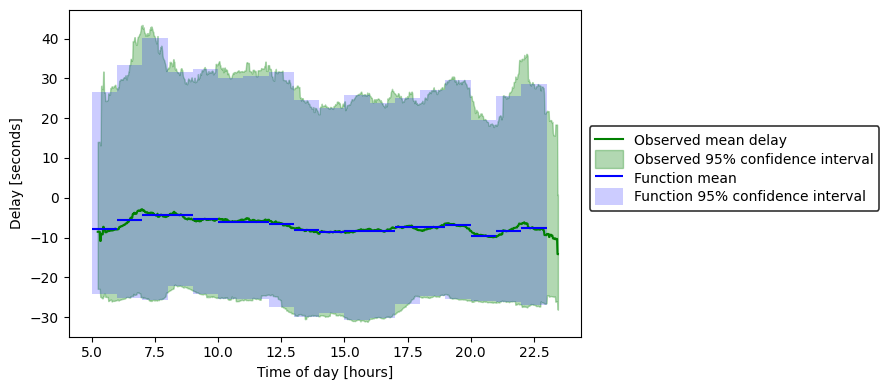

In [11]:
fig = plt.figure(figsize=(9, 4))

# Plot data range
plt.plot(data_times, data_means, 'g', label='Observed mean delay')
plt.fill_between(x=data_times, y1=data_lows, y2=data_highs, color='g', alpha=0.3, label='Observed 95% confidence interval')

# Plot result range
for time, mean, low, high in zip(result_times, result_means, result_lows, result_highs):
    if time == result_times[0]:
        plt.hlines(mean, time, time+1, 'b', label='Function mean')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='b', alpha=0.2, linewidth=0, label='Function 95% confidence interval')
    else:
        plt.hlines(mean, time, time+1, 'b')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='b', alpha=0.2, linewidth=0)

# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=1,handleheight=1.6, labelspacing=0.05)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
fig.savefig(f"Codebase figures\\second_model_delay_diff_confidence.png", dpi=300)

## Against delays

In [12]:
hour_split = {timestep[0]: timestep_data for timestep, timestep_data in matching_values.groupby(['timestep'])}
hour_dfs = []
for timestep, timestep_data in hour_split.items():
    hour_func_params = connection_funcs[connection_funcs['timestep'] == timestep].iloc[0]['dist_params']

    timestep_data['predict_mean'] = timestep_data['delay_prev_stop'] + distribution.mean(*hour_func_params)
    hour_dfs.append(timestep_data)
matching_values = pd.concat(hour_dfs)

In [13]:
matching_values

,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival_time,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train,delay_diff,data_timestep,predict_mean
2970460,ORANGE,D06,D05,D07,-111.0,-96.0,2019-09-16 05:43:00,2019-09-16 05:41:09,5.0,-167.0,2019-09-15 22:53:13,2019-09-15 22:56:00,-15.0,5.716667,-103.928990
3025409,BLUE,D06,D05,D07,-211.0,-192.0,2019-09-16 05:49:00,2019-09-16 05:45:29,5.0,-111.0,2019-09-16 05:41:09,2019-09-16 05:43:00,-19.0,5.816667,-199.928990
2970226,ORANGE,D06,D05,D07,130.0,130.0,2019-09-16 05:51:00,2019-09-16 05:53:10,5.0,-211.0,2019-09-16 05:45:29,2019-09-16 05:49:00,0.0,5.850000,122.071010
3016112,BLUE,D06,D05,D07,86.0,97.0,2019-09-16 05:56:00,2019-09-16 05:57:26,5.0,151.0,2019-09-16 05:55:31,2019-09-16 05:53:00,-11.0,5.933333,89.071010
2997993,ORANGE,D06,D05,D07,108.0,114.0,2019-09-16 05:58:00,2019-09-16 05:59:48,5.0,86.0,2019-09-16 05:57:26,2019-09-16 05:56:00,-6.0,5.966667,106.071010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3358158,BLUE,D06,D05,D07,-100.0,-97.0,2020-03-08 22:15:00,2020-03-08 22:13:20,22.0,90.0,2020-03-08 22:09:30,2020-03-08 22:08:00,-3.0,22.250000,-104.706084
3382365,SILVER,D06,D05,D07,-112.0,-100.0,2020-03-08 22:28:00,2020-03-08 22:26:08,22.0,-100.0,2020-03-08 22:13:20,2020-03-08 22:15:00,-12.0,22.466667,-107.706084
3358522,BLUE,D06,D05,D07,-156.0,-142.0,2020-03-08 22:35:00,2020-03-08 22:32:24,22.0,-112.0,2020-03-08 22:26:08,2020-03-08 22:28:00,-14.0,22.583333,-149.706084
3382846,SILVER,D06,D05,D07,-130.0,-121.0,2020-03-08 22:48:00,2020-03-08 22:45:50,22.0,-156.0,2020-03-08 22:32:24,2020-03-08 22:35:00,-9.0,22.800000,-128.706084


In [14]:
# Create temporal distribution of data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

# matching_values = related_forward_with_diff[(related_forward_with_diff['prev_stop'] == connection[0]) & (related_forward_with_diff['stop'] == connection[1])]

matching_values['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in matching_values['sched_arrival_time'].values]
data_times, data_means, data_highs, data_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = matching_values[(matching_values['data_timestep'] >= timestep-0.5) & (matching_values['data_timestep'] < timestep + 0.5)]['delay'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        data_means.append(distribution.mean(*dist_params))
        data_highs.append(distribution.ppf(high_bound, *dist_params))
        data_lows.append(distribution.ppf(low_bound, *dist_params))
        data_times.append(timestep)

In [15]:
# Create temporal distribution of predicted data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

matching_values['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in matching_values['sched_arrival_time'].values]
mean_predict_times, mean_predict_means, mean_predict_highs, mean_predict_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = matching_values[(matching_values['data_timestep'] >= timestep-0.5) & (matching_values['data_timestep'] < timestep + 0.5)]['predict_mean'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        mean_predict_means.append(distribution.mean(*dist_params))
        mean_predict_highs.append(distribution.ppf(high_bound, *dist_params))
        mean_predict_lows.append(distribution.ppf(low_bound, *dist_params))
        mean_predict_times.append(timestep)

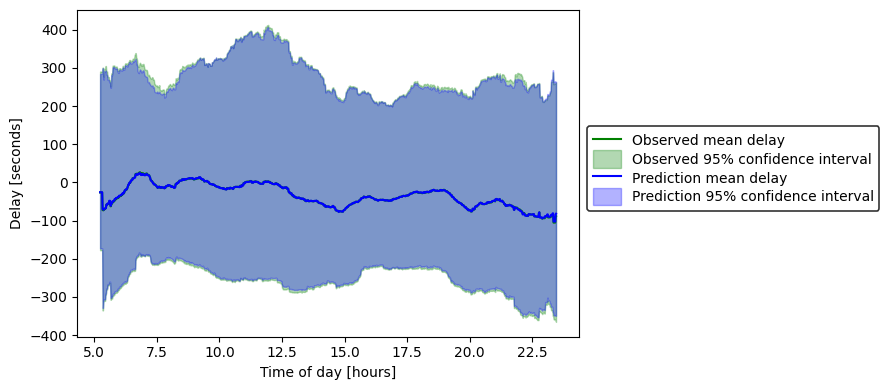

In [16]:
fig = plt.figure(figsize=(9, 4))

# Plot data range
plt.plot(data_times, data_means, 'g', label='Observed mean delay')
plt.fill_between(x=data_times, y1=data_lows, y2=data_highs, color='g', alpha=0.3, label='Observed 95% confidence interval')

# Plot data range
plt.plot(mean_predict_times, mean_predict_means, 'blue', label='Prediction mean delay')
plt.fill_between(x=data_times, y1=mean_predict_lows, y2=mean_predict_highs, color='blue', alpha=0.3, label='Prediction 95% confidence interval')

# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=1,handleheight=1.6, labelspacing=0.05)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
fig.savefig(f"Codebase figures\\second_model_confidence_prediction.png", dpi=300)

# Against previous model

In [23]:
# Settings
current_connection = ('D05', 'D06')
delay_range = 0
other_connection = ('D06', 'D07')

In [24]:
# Find all ocurrences of current connection delays within delay range
ocurrences = matching_values[(matching_values['delay'] >= delay_range * 60) & \
                            (matching_values['delay'] < (delay_range + 1) * 60)].copy()
print(len(ocurrences))
ocurrences.head(5)

4041


,line,stop,prev_stop,next_stop,delay,delay_prev_stop,sched_arrival_time,real_arrival,timestep,delay_ptss,real_arrival_prev_train,sched_arrival_prev_train,delay_diff,data_timestep,predict_mean
2998045,ORANGE,D06,D05,D07,16.0,15.0,2019-09-18 05:58:00,2019-09-18 05:58:16,5.0,-97.0,2019-09-18 05:54:23,2019-09-18 05:56:00,1.0,5.966667,7.07101
2970512,ORANGE,D06,D05,D07,47.0,52.0,2019-09-19 05:43:00,2019-09-19 05:43:47,5.0,-215.0,2019-09-18 22:53:25,2019-09-18 22:57:00,-5.0,5.716667,44.07101
3025463,BLUE,D06,D05,D07,1.0,11.0,2019-09-19 05:49:00,2019-09-19 05:49:01,5.0,47.0,2019-09-19 05:43:47,2019-09-19 05:43:00,-10.0,5.816667,3.07101
2970304,ORANGE,D06,D05,D07,8.0,3.0,2019-09-19 05:51:00,2019-09-19 05:51:08,5.0,1.0,2019-09-19 05:49:01,2019-09-19 05:49:00,5.0,5.850000,-4.92899
3748151,ORANGE,D06,D05,D07,12.0,22.0,2019-09-20 05:58:00,2019-09-20 05:58:12,5.0,-55.0,2019-09-20 05:55:05,2019-09-20 05:56:00,-10.0,5.966667,14.07101


In [25]:
# Create temporal distribution of data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

ocurrences['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in ocurrences['sched_arrival_time'].values]
range_data_times, range_data_means, range_data_highs, range_data_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = ocurrences[(ocurrences['data_timestep'] >= timestep-0.5) & (ocurrences['data_timestep'] < timestep + 0.5)]['delay'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        range_data_means.append(distribution.mean(*dist_params))
        range_data_highs.append(distribution.ppf(high_bound, *dist_params))
        range_data_lows.append(distribution.ppf(low_bound, *dist_params))
        range_data_times.append(timestep)

In [26]:
# Create temporal distribution of data
high_bound = (50 + 95 / 2) / 100
low_bound = (50 - 95 / 2) / 100

ocurrences['data_timestep'] = [pd.Timestamp(arrival_time).hour + pd.Timestamp(arrival_time).minute / 60 for arrival_time in ocurrences['sched_arrival_time'].values]
range_predict_times, range_predict_means, range_predict_highs, range_predict_lows = [], [], [], []
for timestep in np.arange(5, 24, (1 / 60)):  # 10 minute intervals
    values = ocurrences[(ocurrences['data_timestep'] >= timestep-0.5) & (ocurrences['data_timestep'] < timestep + 0.5)]['predict_mean'].values
    values = np.array(values)
    values.sort()

    values = values[~np.isnan(values)]

    if len(values) > 4:
        try:
            dist_params = distribution.fit(values)
        except:
            print(values)
            raise ValueError

        range_predict_means.append(distribution.mean(*dist_params))
        range_predict_highs.append(distribution.ppf(high_bound, *dist_params))
        range_predict_lows.append(distribution.ppf(low_bound, *dist_params))
        range_predict_times.append(timestep)

In [27]:
# Create temporal distribution of results
test = results_first_model[(results_first_model['connection'] == current_connection) & \
                            (results_first_model['other_connection'] == other_connection) & \
                            (results_first_model['delay_range'] == delay_range) & \
                            (results_first_model['timestep'] == results_first_model['future_timestep'])]

result_first_times, result_first_means, result_first_highs, result_first_lows = [], [], [], []
for _, row in test.iterrows():
    dist_params = row['dist_params']

    result_first_times.append(row['timestep'])
    result_first_means.append(distribution.mean(*dist_params))
    result_first_highs.append(distribution.ppf(0.025, *dist_params))
    result_first_lows.append(distribution.ppf(0.975, *dist_params))

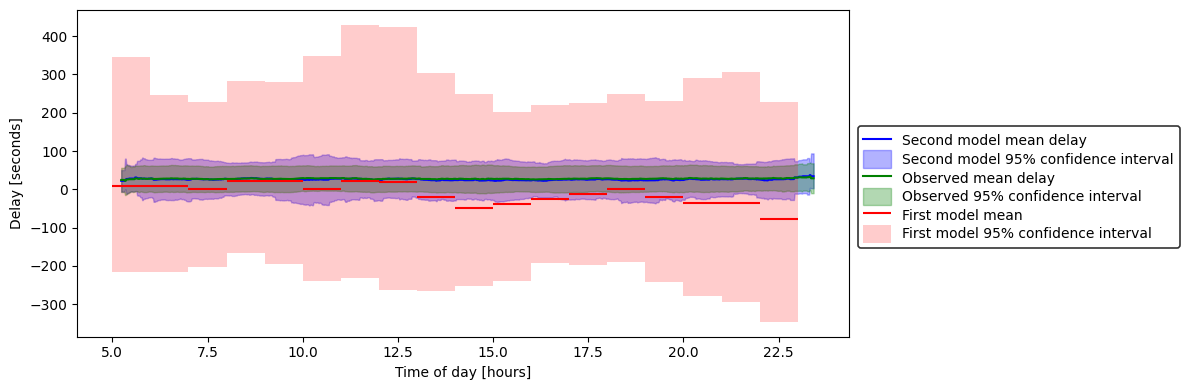

In [28]:
fig = plt.figure(figsize=(12, 4))

# Plot data range
plt.plot(range_predict_times, range_predict_means, 'b', label='Second model mean delay')
plt.fill_between(x=range_predict_times, y1=range_predict_highs, y2=range_predict_lows, color='b', alpha=0.3, label='Second model 95% confidence interval')

# Plot data range
plt.plot(range_data_times, range_data_means, 'g', label='Observed mean delay')
plt.fill_between(x=range_data_times, y1=range_data_highs, y2=range_data_lows, color='g', alpha=0.3, label='Observed 95% confidence interval')

# Plot result range
for time, mean, low, high in zip(result_first_times, result_first_means, result_first_lows, result_first_highs):
    if time == result_times[0]:
        plt.hlines(mean, time, time+1, 'r', label='First model mean')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='r', alpha=0.2, linewidth=0, label='First model 95% confidence interval')
    else:
        plt.hlines(mean, time, time+1, 'r')
        plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color='r', alpha=0.2, linewidth=0)

# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')

legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=1,handleheight=1.6, labelspacing=0.05)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

plt.tight_layout()
fig.savefig(f"Codebase figures\\second_model_first_model_confidence_compare_range_{delay_range}.png", dpi=300)